# Kernel light GBM Kaggle

 HOME CREDIT DEFAULT RISK COMPETITION
 Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
 Little feature selection is done and overfitting might be a problem since many features are related.
 The following key ideas were used:
 - Divide or subtract important features to get rates (like annuity and income)
 - In Bureau Data: create specific features for Active credits and Closed credits
 - In Previous Applications: create specific features for Approved and Refused applications
 - Modularity: one function for each table (except bureau_balance and application_test)
 - One-hot encoding for categorical features
 All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
 You can use LightGBM with KFold or Stratified KFold.

 Update 16/06/2018:
 - Added Payment Rate feature
 - Removed index from features
 - Use standard KFold CV (not stratified)

In [112]:
# conda install -c conda-forge lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time # in Kernel just import time
from os import listdir

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline #, make_union
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.metrics import precision_score, recall_score, make_scorer, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score

rasta = 0

import gc
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# from os import listdir
# path_csvs = 'C:\\Users\\Veronika\\DATABASES\\p7_credit_default_risk_dataset\\'
path_csvs = 'C:\\vb\\DATABASES\\p7_credit_default_risk_dataset\\'

list_files = [file for file in listdir(path_csvs)]

print(list_files)

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
@contextmanager
def timer(title):
    t0 = time()
    yield
    print("{} - done in {:.0f}s".format(title, time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(path_csvs + 'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(path_csvs + 'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path_csvs + 'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path_csvs + 'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path_csvs + 'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path_csvs + 'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path_csvs + 'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path_csvs + 'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)  # here lightgbm error

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

In [4]:
# if __name__ == "__main__":
#     submission_file_name = "submission_kernel02.csv"
#     with timer("Full model run"):
#         main()

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

---------------------------------------------------------------------------
LightGBMError                             Traceback (most recent call last)
C:\Users\OMOREN~1\AppData\Local\Temp/ipykernel_10028/3179020771.py in <module>
      2     submission_file_name = "submission_kernel02.csv"
      3     with timer("Full model run"):
----> 4         main()

C:\Users\OMOREN~1\AppData\Local\Temp/ipykernel_10028/3345960412.py in main(debug)
    321         gc.collect()
    322     with timer("Run LightGBM with kfold"):
--> 323         feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

C:\Users\OMOREN~1\AppData\Local\Temp/ipykernel_10028/3345960412.py in kfold_lightgbm(***failed resolving arguments***)
    253             verbose=-1, )
    254 
--> 255         clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
    256             eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
    257 

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py in fit(self, X, y, sample_weight, init_score, eval_set, eval_names, eval_sample_weight, eval_class_weight, eval_init_score, eval_metric, early_stopping_rounds, verbose, feature_name, categorical_feature, callbacks, init_model)
    965                     valid_sets[i] = (valid_x, self._le.transform(valid_y))
    966 
--> 967         super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
    968                     eval_names=eval_names, eval_sample_weight=eval_sample_weight,
    969                     eval_class_weight=eval_class_weight, eval_init_score=eval_init_score,

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py in fit(self, X, y, sample_weight, init_score, group, eval_set, eval_names, eval_sample_weight, eval_class_weight, eval_init_score, eval_group, eval_metric, early_stopping_rounds, verbose, feature_name, categorical_feature, callbacks, init_model)
    746         callbacks.append(record_evaluation(evals_result))
    747 
--> 748         self._Booster = train(
    749             params=params,
    750             train_set=train_set,

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py in train(params, train_set, num_boost_round, valid_sets, valid_names, fobj, feval, init_model, feature_name, categorical_feature, early_stopping_rounds, evals_result, verbose_eval, learning_rates, keep_training_booster, callbacks)
    269     # construct booster
    270     try:
--> 271         booster = Booster(params=params, train_set=train_set)
    272         if is_valid_contain_train:
    273             booster.set_train_data_name(train_data_name)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py in __init__(self, params, train_set, model_file, model_str, silent)
   2603                 )
   2604             # construct booster object
-> 2605             train_set.construct()
   2606             # copy the parameters from train_set
   2607             params.update(train_set.get_params())

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py in construct(self)
   1813             else:
   1814                 # create train
-> 1815                 self._lazy_init(self.data, label=self.label,
   1816                                 weight=self.weight, group=self.group,
   1817                                 init_score=self.init_score, predictor=self._predictor,

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py in _lazy_init(self, data, label, reference, weight, group, init_score, predictor, silent, feature_name, categorical_feature, params)
   1571             raise TypeError(f'Wrong predictor type {type(predictor).__name__}')
   1572         # set feature names
-> 1573         return self.set_feature_name(feature_name)
   1574 
   1575     @staticmethod

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py in set_feature_name(self, feature_name)
   2140                 raise ValueError(f"Length of feature_name({len(feature_name)}) and num_feature({self.num_feature()}) don't match")
   2141             c_feature_name = [c_str(name) for name in feature_name]
-> 2142             _safe_call(_LIB.LGBM_DatasetSetFeatureNames(
   2143                 self.handle,
   2144                 c_array(ctypes.c_char_p, c_feature_name),

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py in _safe_call(ret)
    123     """
    124     if ret != 0:
--> 125         raise LightGBMError(_LIB.LGBM_GetLastError().decode('utf-8'))
    126 
    127 

LightGBMError: Do not support special JSON characters in feature name.

In [5]:
application_train = pd.read_csv(path_csvs + 'application_train.csv')
# application_train.info()
# application_train.iloc[:, :10].info()

In [59]:
# application_train.nunique()
application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [60]:
application_train.describe(include=object)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511
unique,2,2,2,2,7,8,5,6,6,19,7,58,4,4,8,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,unknown,TUESDAY,Business Entity Type 3,unknown,unknown,unknown,No
freq,278232,202452,202924,213312,249818,158774,218391,196432,272868,96391,53901,67992,215982,154297,156341,159428


In [61]:
application_train.describe(include=int)

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,-16036.995067,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,...,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,4363.988632,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,...,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,-25229.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,-19682.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,-15750.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,-12413.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,-7489.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
application_train.describe(include=float)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307509.000000,134133.000000,3.068510e+05,...,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-4986.120328,12.061091,2.152665,0.502130,5.143927e-01,...,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,3522.886321,11.944812,0.910682,0.211062,1.910602e-01,...,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-24672.000000,0.000000,1.000000,0.014568,8.173617e-08,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-7479.500000,5.000000,2.000000,0.334007,3.924574e-01,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-4504.000000,9.000000,2.000000,0.505998,5.659614e-01,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-2010.000000,15.000000,3.000000,0.675053,6.636171e-01,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,0.000000,91.000000,20.000000,0.962693,8.549997e-01,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


# Impute missing values

## Strategy
### Cautious strategy
The strategy is not the same for filling the train set and the test set:
- For the test set, if we don't know the value, we shall use the most "risky" variant: the value that gives the highest rate of positive target.
- For the train set, we know the traget. So, if the target is negative, no need to set the parameter to the "most risky" category. I will assign it to the a category (more on that later), if the number of missing values is below the limit (let's say arbitrarily, 5%) and to a standalone "unknown" category, if the number of missing values is above this limit.
- How to choose a category: we already know the target value. So, for the positive target we give the "most risky" value to the unknown. For the negative target, we give the most frequent value, doesn't matter what's the risk (can be the most risky, the least, or somewhere in the middle, we just take the most frequent).
- The drawback of such a distiction on the category: we risk to overfit our model. But, we will overfit it in a lopsided way: the model will tend to give more importance on the imputed features to lead to positive target. But this drawback plays on our side at the end of the game: as on test set we impute the "most risky" value every time, the model will give more false negatives, but will be much less likely to let pass the false positives. That means, we can explain the refuse to a client based on the features that were not provided by the client, so the client knows what cells (s)he has to modify or fill.
- How we detect "the most risky" category: by groupby-aggregation test. Look the correlation between positive target (credit fail) and different values. See the proportion of people who failed to pay their credit for every value. The value with the highest proportion of positive target is "the most risky" one.
- How to store "the most risky" values: maybe as a dictionary. The key is the feature that we want to impute, the value is the most risky category.
### When to apply cautious strategy
When we suppose that a false positive is significantly more costly to the bank than a false negative is. If it happens that the difference between the cost of false negative and false positive is insignificant for the bank, we can pass to simplified strategy.
### Simplified strategy
Impute with "the most risky" value for test set and with the most frequent value for the train set.
### Simplest strategy
Impute with the most frequent value for both train and test sets.
### How to handle the values which are already imputed as "unknown" or similar
When you look through unique values, you might notice that some categorical values are filled with "unknown", "not_specified", "XNA" or similar kinds of values. All that means "NaN", basically.
The best of all would be to ask a confirmation on the business side, whether it's indeed smth like "this info is lacking", which equelas NaN.

If it is so, the best is to delete these values/replace by "NaN", and then apply the standard algorithm, described before.

Example: GENDER_CODE. Among 307511 applications, 4 applicants have "XNA" value. It's like "nan", just it's filled with text. So I will replace "XNA" with "nan", and then treat it along the general algorithm:
    it's less than 5% NaNs, so impute 
    -with most risky for test set, 
    -with  most risky for train set positive target, 
    - with most frequent for train set negtive target.
The most risky value from groupby-aggreagtion test is "M".

In [6]:
catcol = application_train.select_dtypes(include='object')
catcol.info()
catcol.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   NAME_CONTRACT_TYPE          307511 non-null  object
 1   CODE_GENDER                 307511 non-null  object
 2   FLAG_OWN_CAR                307511 non-null  object
 3   FLAG_OWN_REALTY             307511 non-null  object
 4   NAME_TYPE_SUITE             306219 non-null  object
 5   NAME_INCOME_TYPE            307511 non-null  object
 6   NAME_EDUCATION_TYPE         307511 non-null  object
 7   NAME_FAMILY_STATUS          307511 non-null  object
 8   NAME_HOUSING_TYPE           307511 non-null  object
 9   OCCUPATION_TYPE             211120 non-null  object
 10  WEEKDAY_APPR_PROCESS_START  307511 non-null  object
 11  ORGANIZATION_TYPE           307511 non-null  object
 12  FONDKAPREMONT_MODE          97216 non-null   object
 13  HOUSETYPE_MODE              1

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [7]:
# how many NaNs, percentage
for col in catcol:
    print(col, application_train[col].isna().sum() / application_train.shape[0] * 100)

NAME_CONTRACT_TYPE 0.0
CODE_GENDER 0.0
FLAG_OWN_CAR 0.0
FLAG_OWN_REALTY 0.0
NAME_TYPE_SUITE 0.42014757195677555
NAME_INCOME_TYPE 0.0
NAME_EDUCATION_TYPE 0.0
NAME_FAMILY_STATUS 0.0
NAME_HOUSING_TYPE 0.0
OCCUPATION_TYPE 31.345545362604916
WEEKDAY_APPR_PROCESS_START 0.0
ORGANIZATION_TYPE 0.0
FONDKAPREMONT_MODE 68.38617155158677
HOUSETYPE_MODE 50.176091261776
WALLSMATERIAL_MODE 50.8407829313423
EMERGENCYSTATE_MODE 47.39830445089769


In [8]:
catcol_fill_targ = catcol.fillna('unknown')
catcol_fill_targ['SK_ID_CURR'] = application_train['SK_ID_CURR']
catcol_fill_targ['TARGET'] = application_train['TARGET']

def find_most_risky(mycol, show=True):
    if show:
        print(catcol_fill_targ[mycol].value_counts())

    # test = application_train.groupby(['TARGET', 'CODE_GENDER']).agg('count').iloc[:, 0].unstack().fillna(0)
    test = catcol_fill_targ.groupby(['TARGET', mycol])['SK_ID_CURR'].agg('count').unstack().fillna(0)
    # sns.heatmap(test, annot=True, cmap='Blues', fmt='g')
    test_t = test.transpose()

    test1 = pd.DataFrame() # which proportion of every value has failed the credit 
    for col in test: # how high chances are that a given person with a given value will fail the credit
        test1[col] = test[col] / test[col].sum() * 100
    display(test1.transpose().sort_values(1, ascending=False))
    
#     # this table we dont' need to define the most risky category
#         test2 = pd.DataFrame() # who failed the credit: among failers, what are the proportion of each value
#     for col in test_t:
#         test2[col] = test_t[col] / test_t[col].sum() * 100
#     display(test2) # given that the person has failed the credit, how high are the chances that (s)he is in each category

In [9]:
# find_most_risky('NAME_CONTRACT_TYPE') # cash 8.3, revolving 5.4
# find_most_risky('CODE_GENDER') # F 7.0, M 10.1, XNA equals NaN 0 (0 out of 4 people)
# find_most_risky('FLAG_OWN_CAR') # No 8.5, Yes 7.2
# find_most_risky('FLAG_OWN_REALTY') # No 8.32 Yes 7.96
# find_most_risky('NAME_TYPE_SUITE') # NaN 5.4(min), Other_B 9.8 (max value)
# find_most_risky('NAME_INCOME_TYPE') # Businessman 0(min value), maternity leave 40 (max value), unemployed 36.4
# find_most_risky('NAME_EDUCATION_TYPE') # correlation, monotonic but not proportional! academic 1.8, lower secondary 10.9
# find_most_risky('NAME_FAMILY_STATUS') # widow 5.8(min), civil marriage 9.9, single 9.8, unknown = NaN 0 (0 out of 2)
# find_most_risky('NAME_HOUSING_TYPE') # office appartment 6.5(min), rented apartment 12.3 (max value), with parents 11.7
# find_most_risky('OCCUPATION_TYPE') # accountants 4.8(min), low-skill Laborers 17.1 (max value)
# find_most_risky('WEEKDAY_APPR_PROCESS_START') # Mon7.75(min), Sat7.78, Sun7.92, Tue8.35(max). Remove this feature.
# find_most_risky('ORGANIZATION_TYPE') # tradeType4 3.12(min), transportType3 15.75(max) 58 columns!
# find_most_risky('FONDKAPREMONT_MODE') # orgSpecAcc 5.8 (min), unknown 8.6 (max), "not specified" means NaN 7.5
# find_most_risky('HOUSETYPE_MODE') # blockOfFLats 6.9, specificHousing 10.1(max), NaN 9.15
# find_most_risky('WALLSMATERIAL_MODE') # Monolithic 4.72(min), wooden 9.69, unknown 9.12
find_most_risky('EMERGENCYSTATE_MODE') # No 7.0, Yes 9.57, NaN 9.26

No         159428
unknown    145755
Yes          2328
Name: EMERGENCYSTATE_MODE, dtype: int64


TARGET,0,1
Yes,90.420962,9.579038
unknown,90.739254,9.260746
No,93.035100,6.964900


NAME_TYPE_SUITE 0.42014757195677555
OCCUPATION_TYPE 31.345545362604916
FONDKAPREMONT_MODE 68.38617155158677
HOUSETYPE_MODE 50.176091261776
WALLSMATERIAL_MODE 50.8407829313423
EMERGENCYSTATE_MODE 47.39830445089769

### What we see for missing categorical values

CODE_GENDER: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 0 to 7.0. With cautious strategy - rise even higher, from 0 to 10.1. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.001%, we can't take them into a separated category_

NAME TYPE SUITE: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 5.4 to 8.2. With cautious strategy - rise even higher, from 5.4 to 9.8. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.42%, we can't take them into a separated category_

OCCUPATION_TYPE: With the simplest strategy we tend to rise the failure impact from 6.5 to 10.5 (most frequent group is Laborers). With cautious strategy - rise even higher, from 6.5 to 17.1. __Simplest__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart, and this is better than both simplest or cautious_

FONDCAPREMONT: With the simplest strategy we tend to bring down the failure impact from 8.6 to 7.0 (most frequent group is reg oper account). With cautious strategy - bring down less, from 8.6 to 7.5. __Cautious__ strategy is closer to reality.
Here, as we have the category "not specified", we can combine them. That would be equal to cautious strategy.
Or, _as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension, so let's just replace "not specified" with NaN and combine with NaNs into a separate category._

HOUSETYPE_MODE: With the simplest strategy we tend to bring down the failure impact from 9.15 to 7.0 (most frequent group is block of flats). With cautious strategy - to rise the failure from 9.15 to 10.1. __Cautious__ strategy is closer to reality.
Here, as we have the category "not specified", we can combine them. That would be equal to cautious strategy.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

WALLSMATERIAL_MODE: With the simplest strategy we tend to bring down the failure impact from 9.1 to 6.3 (most frequent group is panel). With cautious strategy - to rise the failure from 9.1 to 9.7. __Cautious__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

EMERGENCYSTATE_MODE: With the simplest strategy we tend to bring down the failure impact from 9.3 to 7.0 (most frequent group is No). With cautious strategy - to rise the failure from 9.3 to 9.6. __Cautious__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

At this step, I will replace all the missing values with simplest strategy, but I will choose the string to fill by different strategies: simplest where it's closer to reality, cautious where it's closer to reality.

In [10]:
# application_train.NAME_TYPE_SUITE.value_counts()
# application_train.OCCUPATION_TYPE.value_counts()
# application_train.FONDKAPREMONT_MODE.value_counts()
# application_train.HOUSETYPE_MODE.value_counts()
# application_train.WALLSMATERIAL_MODE.value_counts()
application_train.EMERGENCYSTATE_MODE.value_counts()

No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

In [11]:
application_train.loc[application_train.CODE_GENDER == 'XNA', 'CODE_GENDER'] = 'F' # as most frequent
application_train.loc[application_train.FONDKAPREMONT_MODE == 'not specified', 'FONDKAPREMONT_MODE'] = 'unknown' # "not specified" in fact means NaN


application_train['NAME_TYPE_SUITE'] = application_train.NAME_TYPE_SUITE.fillna('Unaccompanied') # as most frequent
application_train['OCCUPATION_TYPE'] = application_train.OCCUPATION_TYPE.fillna('unknown') # new category
application_train['FONDKAPREMONT_MODE'] = application_train.FONDKAPREMONT_MODE.fillna('unknown') # merge with "not specified"
application_train['HOUSETYPE_MODE'] = application_train.HOUSETYPE_MODE.fillna('unknown') # as most frequent
application_train['WALLSMATERIAL_MODE'] = application_train.WALLSMATERIAL_MODE.fillna('unknown') # as most frequent
application_train['EMERGENCYSTATE_MODE'] = application_train.EMERGENCYSTATE_MODE.fillna('Yes') # as most risky


In [12]:
# application_train.NAME_TYPE_SUITE.value_counts()
# application_train.OCCUPATION_TYPE.value_counts()
# application_train.FONDKAPREMONT_MODE.value_counts()
# application_train.HOUSETYPE_MODE.value_counts()
# application_train.WALLSMATERIAL_MODE.value_counts()
application_train.EMERGENCYSTATE_MODE.value_counts()

No     159428
Yes    148083
Name: EMERGENCYSTATE_MODE, dtype: int64

In [13]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(path_csvs + 'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(path_csvs + 'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


In [14]:
# bureau = pd.read_csv(path_csvs + 'bureau.csv')
# bureau.info()

bureau table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1,716,428 entries, 0 to 1,716,427
Data columns (total 17 columns):
    Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB

In [15]:
# bureau_balance = pd.read_csv(path_csvs + 'bureau_balance.csv')
# bureau_balance.info()

bureau_balance table: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27,299,925 entries, 0 to 27,299,924
Data columns (total 3 columns):
     Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB

In [16]:
# credit_card_balance = pd.read_csv(path_csvs + 'credit_card_balance.csv')
# credit_card_balance.info()

credit_card_balance table: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3,840,312 entries, 0 to 3,840,311
Data columns (total 23 columns):
     Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE_CUM   float64
 20  NAME_CONTRACT_STATUS        object 
 21  SK_DPD                      int64  
 22  SK_DPD_DEF                  int64  
dtypes: float64(15), int64(7), object(1)
memory usage: 673.9+ MB

In [17]:
# installments_payments = pd.read_csv(path_csvs + 'installments_payments.csv')
# installments_payments.info()

installments_payments table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13,605,401 entries, 0 to 13,605,400
Data columns (total 8 columns):
     Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB

In [18]:
# POS_CASH_balance = pd.read_csv(path_csvs + 'POS_CASH_balance.csv')
# POS_CASH_balance.info()

POS_CASH_balance table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10,001,358 entries, 0 to 10,001,357
Data columns (total 8 columns):
     Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB

In [19]:
# previous_application = pd.read_csv(path_csvs + 'previous_application.csv')
# previous_application.info()

previous_application table: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1,670,214 entries, 0 to 1,670,213
Data columns (total 37 columns):
     Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-null   float64
 13  RATE_INTEREST_PRIMARY        5951 non-null     float64
 14  RATE_INTEREST_PRIVILEGED     5951 non-null     float64
 15  NAME_CASH_LOAN_PURPOSE       1670214 non-null  object 
 16  NAME_CONTRACT_STATUS         1670214 non-null  object 
 17  DAYS_DECISION                1670214 non-null  int64  
 18  NAME_PAYMENT_TYPE            1670214 non-null  object 
 19  CODE_REJECT_REASON           1670214 non-null  object 
 20  NAME_TYPE_SUITE              849809 non-null   object 
 21  NAME_CLIENT_TYPE             1670214 non-null  object 
 22  NAME_GOODS_CATEGORY          1670214 non-null  object 
 23  NAME_PORTFOLIO               1670214 non-null  object 
 24  NAME_PRODUCT_TYPE            1670214 non-null  object 
 25  CHANNEL_TYPE                 1670214 non-null  object 
 26  SELLERPLACE_AREA             1670214 non-null  int64  
 27  NAME_SELLER_INDUSTRY         1670214 non-null  object 
 28  CNT_PAYMENT                  1297984 non-null  float64
 29  NAME_YIELD_GROUP             1670214 non-null  object 
 30  PRODUCT_COMBINATION          1669868 non-null  object 
 31  DAYS_FIRST_DRAWING           997149 non-null   float64
 32  DAYS_FIRST_DUE               997149 non-null   float64
 33  DAYS_LAST_DUE_1ST_VERSION    997149 non-null   float64
 34  DAYS_LAST_DUE                997149 non-null   float64
 35  DAYS_TERMINATION             997149 non-null   float64
 36  NFLAG_INSURED_ON_APPROVAL    997149 non-null   float64
dtypes: float64(15), int64(6), object(16)
memory usage: 471.5+ MB

In [20]:
# previous_application.select_dtypes(include='object').info()

previous_application (dtype = object) table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1,670,214 entries, 0 to 1,670,213
Data columns (total 16 columns):
     Column                       Non-Null Count    Dtype 
---  ------                       --------------    ----- 
 0   NAME_CONTRACT_TYPE           1670214 non-null  object
 1   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object
 2   FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object
 3   NAME_CASH_LOAN_PURPOSE       1670214 non-null  object
 4   NAME_CONTRACT_STATUS         1670214 non-null  object
 5   NAME_PAYMENT_TYPE            1670214 non-null  object
 6   CODE_REJECT_REASON           1670214 non-null  object
 7   NAME_TYPE_SUITE              849809 non-null   object
 8   NAME_CLIENT_TYPE             1670214 non-null  object
 9   NAME_GOODS_CATEGORY          1670214 non-null  object
 10  NAME_PORTFOLIO               1670214 non-null  object
 11  NAME_PRODUCT_TYPE            1670214 non-null  object
 12  CHANNEL_TYPE                 1670214 non-null  object
 13  NAME_SELLER_INDUSTRY         1670214 non-null  object
 14  NAME_YIELD_GROUP             1670214 non-null  object
 15  PRODUCT_COMBINATION          1669868 non-null  object
dtypes: object(16)
memory usage: 203.9+ MB

In [21]:
# sample_submission = pd.read_csv(path_csvs + 'sample_submission.csv')
# sample_submission.info()

sample_submission table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48,744 entries, 0 to 48,743
Data columns (total 2 columns):
     Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB

In [22]:
# HomeCredit_columns_description = pd.read_csv(path_csvs + 'HomeCredit_columns_description.csv')
# UnicodeDecodeError: 'utf-8' codec can't decode byte 0x85 in position 1283: invalid start byte

HomeCredit_columns_description = pd.read_csv(path_csvs + 'HomeCredit_columns_description.csv', encoding= 'unicode_escape')
HomeCredit_columns_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


Clients income type (businessman, working, maternity leave,)

The unreadable symbol is an ellipsis. When I replaced it with "etc.", it raised an error in a later position: 26,931 instead of 1283.

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x85 in position 26931: invalid start byte


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
     Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Number       219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB

# The description of all the columns of all the tables

In [23]:
# print(pd.get_option('display.max_colwidth'))
pd.set_option('max_colwidth', None)
# print(pd.get_option('display.max_colwidth'))
display(HomeCredit_columns_description.head(3))
# print(pd.get_option('display.max_colwidth'))
# pd.reset_option('max_colwidth')

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN


In [24]:
HomeCredit_columns_description.Description[1]
# HomeCredit_columns_description.Description.map(print)

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

In [25]:
HomeCredit_columns_description.Table.unique()

array(['application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

In [26]:
pd.set_option('max_rows', None)
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'application_{train|test}.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
5,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,CNT_CHILDREN,Number of children the client has
7,AMT_INCOME_TOTAL,Income of the client
8,AMT_CREDIT,Credit amount of the loan
9,AMT_ANNUITY,Loan annuity


In [27]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'bureau.csv', ['Description']]
# pd.reset_option('max_rows')

,Description
122,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau"
123,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)
124,Status of the Credit Bureau (CB) reported credits
125,Recoded currency of the Credit Bureau credit
126,How many days before current application did client apply for Credit Bureau credit
127,Number of days past due on CB credit at the time of application for related loan in our sample
128,Remaining duration of CB credit (in days) at the time of application in Home Credit
129,Days since CB credit ended at the time of application in Home Credit (only for closed credit)
130,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
131,How many times was the Credit Bureau credit prolonged


In [28]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'POS_CASH_balance.csv', ['Description']]
# pd.reset_option('max_rows')

,Description
142,"ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)"
143,ID of loan in our sample
144,"Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )"
145,Term of previous credit (can change over time)
146,Installments left to pay on the previous credit
147,Contract status during the month
148,DPD (days past due) during the month of previous credit
149,DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit


In [29]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'credit_card_balance.csv', ['Description']]
# pd.reset_option('max_rows')

,Description
150,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)"
151,ID of loan in our sample
152,Month of balance relative to application date (-1 means the freshest balance date)
153,Balance during the month of previous credit
154,Credit card limit during the month of the previous credit
155,Amount drawing at ATM during the month of the previous credit
156,Amount drawing during the month of the previous credit
157,Amount of other drawings during the month of the previous credit
158,Amount drawing or buying goods during the month of the previous credit
159,Minimal installment for this month of the previous credit


In [30]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'previous_application.csv', ['Description']]
# pd.reset_option('max_rows')

,Description
173,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit)"
174,ID of loan in our sample
175,"Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application"
176,Annuity of previous application
177,For how much credit did client ask on the previous application
178,"Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT"
179,Down payment on the previous application
180,Goods price of good that client asked for (if applicable) on the previous application
181,On which day of the week did the client apply for previous application
182,Approximately at what day hour did the client apply for the previous application


In [31]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'installments_payments.csv', ['Description']]
# pd.reset_option('max_rows')

,Description
211,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)"
212,ID of loan in our sample
213,Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
214,On which installment we observe payment
215,When the installment of previous credit was supposed to be paid (relative to application date of current loan)
216,When was the installments of previous credit paid actually (relative to application date of current loan)
217,What was the prescribed installment amount of previous credit on this installment
218,What the client actually paid on previous credit on this installment


In [32]:
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Special.notna(), ['Description', 'Special']].apply(print)
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Special.notna(), ['Description', 'Special']].applymap(print)
HomeCredit_columns_description.loc[HomeCredit_columns_description.Special.notna(), ['Description', 'Special']]

,Description,Special
16,Normalized population of region where client lives (higher number means the client lives in more populated region),normalized
17,Client's age in days at the time of application,time only relative to the application
18,How many days before the application the person started current employment,time only relative to the application
19,How many days before the application did client change his registration,time only relative to the application
20,How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application
33,Approximately at what hour did the client apply for the loan,rounded
41,Normalized score from external data source,normalized
42,Normalized score from external data source,normalized
43,Normalized score from external data source,normalized
44,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized


## Exploration de données

In [33]:
pd.reset_option("max_rows")
pd.get_option("max_rows")

60

In [34]:
# filled_values = application_train.count().sort_values(ascending=False)
# filled_values
# diversity = application_train.nunique().sort_values()
# diversity

display(application_train.count().sort_values(ascending=False))
display(application_train.nunique().sort_values())

SK_ID_CURR                     307511
HOUR_APPR_PROCESS_START        307511
REG_REGION_NOT_WORK_REGION     307511
LIVE_REGION_NOT_WORK_REGION    307511
FONDKAPREMONT_MODE             307511
                                ...  
NONLIVINGAPARTMENTS_MODE        93997
NONLIVINGAPARTMENTS_MEDI        93997
COMMONAREA_MODE                 92646
COMMONAREA_AVG                  92646
COMMONAREA_MEDI                 92646
Length: 122, dtype: int64

LIVE_CITY_NOT_WORK_CITY         2
FLAG_DOCUMENT_13                2
FLAG_MOBIL                      2
FLAG_EMP_PHONE                  2
FLAG_WORK_PHONE                 2
                            ...  
DAYS_REGISTRATION           15688
DAYS_BIRTH                  17460
EXT_SOURCE_1               114584
EXT_SOURCE_2               119831
SK_ID_CURR                 307511
Length: 122, dtype: int64

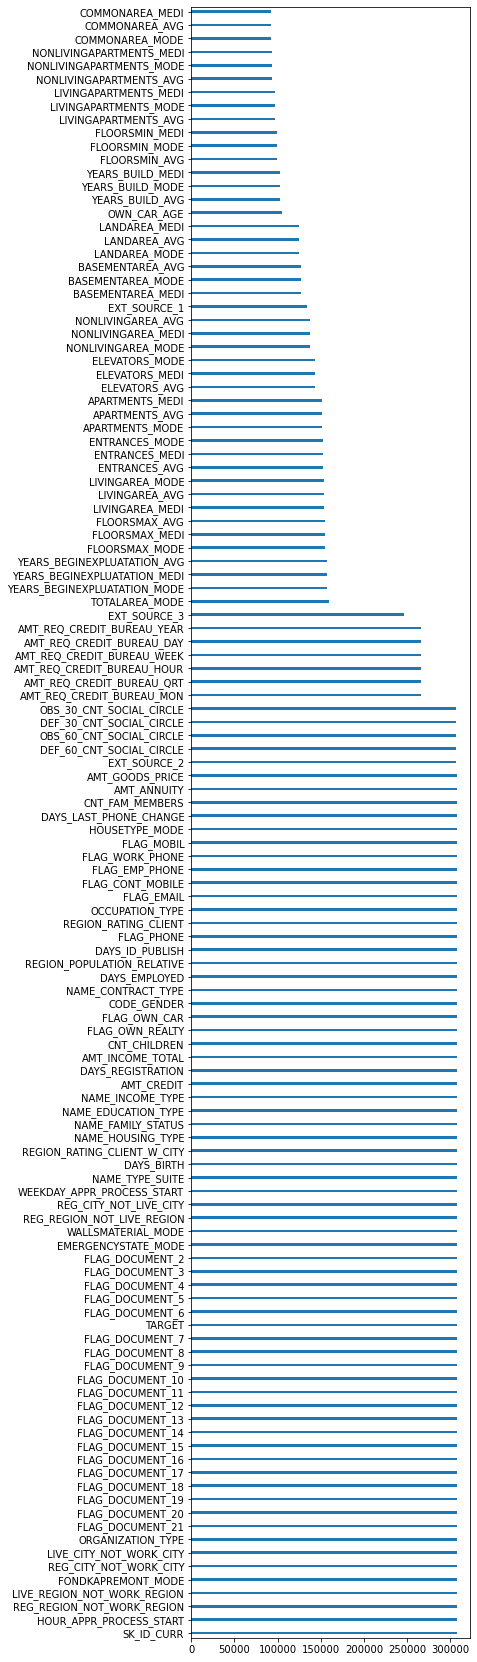

In [36]:
# filled_values.plot(kind='barh', figsize=(5, 30), width=0.2)
application_train.count().sort_values(ascending=False).plot(kind='barh', figsize=(5, 30), width=0.2)

plt.show()

In [37]:
test = application_train.TARGET.value_counts()
print(test)
print(f'{round(test[1] / application_train.shape[0] * 100, 3)}% users fail to pay their loans')

0    282686
1     24825
Name: TARGET, dtype: int64
8.073% users fail to pay their loans


Juste 8% d'utilisateurs ne rembourse pas leurs crédits, pourtant il est essentiel de détecter ceux-ci.

In [38]:
application_train.NAME_CONTRACT_TYPE.value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

10% d'utilisateurs prennent des crédits recurrents, la majorité prend des crédits au term.

In [39]:
application_train.DAYS_BIRTH

0         -9461
1        -16765
2        -19046
3        -19005
4        -19932
          ...  
307506    -9327
307507   -20775
307508   -14966
307509   -11961
307510   -16856
Name: DAYS_BIRTH, Length: 307511, dtype: int64

# Data cleaning

The simplest cleaning consist of remove all the columns that have NaN values, then keeping only the columns that have 2 or 3 unique values. If we have more than 10 dimensions, we can test it as a dummy model.

In [40]:
data_cleaned = application_train.dropna(axis=1).copy()
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 61 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   NAME_TYPE_SUITE              307511 non-null  object 
 10  NAME_INCOME_TYPE             307511 non-null  object 
 11  NAME_EDUCATION_TYPE          307511 non-null  object 
 12  NAME_FAMILY_STATUS           307511 non-null  object 
 13 

In [42]:
data_cleaned = data_cleaned.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis=1)

# Train test split

Stratified train test split which preserves the proportion of negative and positive as in whe whole dataset (8% positives in both train split and test split)

In [45]:
data_train, data_test = train_test_split(data_cleaned, test_size=0.2, random_state = rasta, stratify=data_cleaned.TARGET)

In [46]:
X_train = data_train.drop('TARGET', axis=1)
X_test = data_test.drop('TARGET', axis=1)
y_train = data_train.TARGET
y_test = data_test.TARGET
X_full = data_cleaned.drop('TARGET', axis=1)

# Dummy classifier

We work with a database which has a major and a minor class, where the detection of the minor class is super-important. Let's call the minor class (fail to pay the credit) positive, and major class (manages to pay the credit) negative.
Then the dummy classifier will always predict the negative class.

The DummyClassifier Method in Scikit Learn uses "prior" strategy. The "predict" method always returns the most frequent class label in the observed y argument passed to fit (like "most_frequent). 

The "predict_proba" always returns the empirical class distribution of y also known as the empirical class prior distribution. In our case it means it will return the probabiliteis proportionally to what it have seen at fitting stage: 92% negative, 8% positive.

Meanwhile the "predict_proba" with "most_frequent" strategy returns the matching one-hot encoded vector, which means vector composed of 0s in our case or of 1s.

In [47]:
dummy_clf = DummyClassifier(strategy='prior')
dummy_clf.fit(X_train, y_train)
# dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.9192722306228964

As we see, the dummy classifier has 92% accuracy.

The metric that interests us, is how much of positives are correctlu detected. How much of the positives are true positives. How much of negatives are false negatives. The objective is to have as few false negatives as possible.

# Precision and recall

Precision allows not to mark a reliable client as a suspicious one. HIgher the precision, better this probability is. 
It shows how many clients are really failsome, out of predicted as such.

Recall allows not to mark a suspicious client as a reliable one. This metric is essential, the priority should be given to it. It shows how many positives were picked up and not missed, out of all existing failsome clients.

From the other hand, an algoritm that marks everyone as suspicious, would have 100% of recall, but have bad other metrics, and would be a useless model. So the balance should be found between the recall and other metrics (like precision or maybe others).

The balance can be found with 1F score.

In [67]:
print(len(y_test), "test values")
print(y_test.sum(), "positive values in test set")

61503 test values
4965 positive values in test set


In [68]:
errors = []

In [83]:
def compare_model(model_name):
    time1 = time()
    print('Fitting started')
    model.fit(X_train, y_train)
    time2 = time()
    print('The fit completed in', time2 - time1, 'seconds')

    y_pred_train = model.predict(X_train)
    errors.append([model_name, 'from_train',
    #                round(model.score(X_train, y_train), 3), 
                   round(precision_score(y_train, y_pred_train), 3),
                   round(recall_score(y_train, y_pred_train), 3), 
                   round((time2 - time1), 3)])

    y_pred = model.predict(X_test)
    errors.append([model_name, 'from_test',
    #                round(model.score(X_test, y_test), 3), 
                   round(precision_score(y_test, y_pred), 3), 
                   round(recall_score(y_test, y_pred), 3), 
                   round((time2 - time1), 3)])

    time3 = time()
    print('train and test predictions completed in', time3 - time2, 'seconds')
    return y_pred, y_pred_train

In [70]:
model = DummyClassifier(strategy='prior')
compare_model('Dummy')

Fitting started
The fit completed in 0.01500391960144043 seconds
train and test predictions completed in 0.1830120086669922 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Pipeline, preprocessor: StandardScaler, OnehotEncoder

In [71]:
preprocessor = make_column_transformer(
    (StandardScaler(),
     X_full.select_dtypes(include=['int64','float64']).columns),
    (OneHotEncoder
     (categories = [X_full[feature].unique() for feature in X_full.select_dtypes(exclude=['int64','float64']).columns],
      drop='first'),
     X_full.select_dtypes(exclude=['int64','float64']).columns))

Technics to overcome imbalanced classes:
class weight = 'balanced', smote, oversampling, undersampling

In [84]:
# smaller C means stronger regularization
# Cs as integer provides equally distributed C from 10^-4 to 10^4
# model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

model = make_pipeline(preprocessor, 
                      LogisticRegressionCV(class_weight='balanced',
                                           scoring='roc_auc',
                                           cv=3, 
                                           tol=0.01, 
                                           max_iter=10_000))

# with max_iter = 1000, STOP: TOTAL NO. of ITERATIONS REACHED LIMIT. 2 times (out of 10 Cs tested)

y_pred, y_pred_train = compare_model('LogRegCV')

Fitting started
The fit completed in 424.26278471946716 seconds
train and test predictions completed in 2.3129289150238037 seconds


In [81]:
model = make_pipeline(preprocessor, 
                      RandomForestClassifier(class_weight='balanced',
                                            ))
y_pred, y_pred_train = compare_model('Forest')

Fitting started
The fit completed in 109.49307990074158 seconds
train and test predictions completed in 13.218888282775879 seconds


In [78]:
model = make_pipeline(preprocessor, 
                      PassiveAggressiveClassifier(class_weight='balanced',
#                                            scoring='roc_auc',
#                                            cv=3, 
                                           tol=0.01, 
                                           max_iter=10_000))

# with max_iter = 1000, STOP: TOTAL NO. of ITERATIONS REACHED LIMIT. 2 times (out of 10 Cs tested)

y_pred, y_pred_train = compare_model('PassAggr')

Fitting started
The fit completed in 4.023304462432861 seconds
train and test predictions completed in 2.294163703918457 seconds


In [85]:
errors

[['Dummy', 'from_train', 0.0, 0.0, 0.015],
 ['Dummy', 'from_test', 0.0, 0.0, 0.015],
 ['LogRegCV', 'from_train', 0.127, 0.629, 440.884],
 ['LogRegCV', 'from_test', 0.127, 0.627, 440.884],
 ['PassAggr', 'from_train', 0.096, 0.679, 4.023],
 ['PassAggr', 'from_test', 0.096, 0.681, 4.023],
 ['Forest', 'from_train', 1.0, 0.999, 109.493],
 ['Forest', 'from_test', 0.0, 0.0, 109.493],
 ['LogRegCV', 'from_train', 0.127, 0.629, 424.263],
 ['LogRegCV', 'from_test', 0.127, 0.627, 424.263]]

We see that RandomForest is highly overfitted.

When the score was 'accuracy', the precision was 0, which meant that I have no positive predictions.

Maybe the standard methods of cross-validation don't fit, because they select the "best" parameter (what they believe to be the best) depending on the highest accuracy. Which is the highest when the model predicts only 0s.

When I changed the score to "roc_auc" based on the list of available scores, the precision is higher tahn 0, as well as the recall. Even though it's far from being good.

# Personalized metric: with make scorer?

In [66]:
print(sorted(sklearn.metrics.SCORERS.keys()))
sklearn.metrics.SCORERS

{'explained_variance': make_scorer(explained_variance_score),
 'r2': make_scorer(r2_score),
 'max_error': make_scorer(max_error, greater_is_better=False),
 'neg_median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
 'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'neg_mean_absolute_percentage_error': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
 'neg_mean_squared_log_error': make_scorer(mean_squared_log_error, greater_is_better=False),
 'neg_root_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
 'neg_mean_poisson_deviance': make_scorer(mean_poisson_deviance, greater_is_better=False),
 'neg_mean_gamma_deviance': make_scorer(mean_gamma_deviance, greater_is_better=False),
 'accuracy': make_scorer(accuracy_score),
 'top_k_accuracy': make_scorer(top_k_accuracy_score, ne

In [108]:
print(sum((y_test.values == 1) & (y_pred == 1)))
print(sum((y_test.values == 1) | (y_pred == 1)))
print(sum((y_test.values == 1) & (y_pred == 0)))
print(sum((y_test.values == 0) & (y_pred == 1)))

3113
26332
1852
21367


In [109]:
def my_metric(false_neg_coef=10, false_pos_coef=1):
    false_neg = sum((y_test.values == 1) & (y_pred == 0))
    false_pos = sum((y_test.values == 0) & (y_pred == 1))
    return false_neg_coef * false_neg + false_pos_coef * false_pos

I'm not sure that my_metric will work correctly. y_test is ok, it's predefined in global space. But what about y_pred? It takes values from the tests defined before. Maybe even in previous models.

In [115]:
make_scorer(my_metric)

make_scorer(my_metric)

In [117]:
# my_scoring = {'perso': make_scorer(my_metric), 'AUC': 'roc_auc'}
my_scoring = {'perso': make_scorer(my_metric)}

In [119]:
# smaller C means stronger regularization
# Cs as integer provides equally distributed C from 10^-4 to 10^4
# model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

model = make_pipeline(preprocessor, 
                      LogisticRegressionCV(class_weight='balanced',
#                                            scoring = my_scoring,
                                           scoring = make_scorer(my_metric),
                                           cv=3, 
                                           tol=0.01, 
                                           max_iter=10_000))

# with max_iter = 1000, STOP: TOTAL NO. of ITERATIONS REACHED LIMIT. 2 times (out of 10 Cs tested)

y_pred, y_pred_train = compare_model('My_metric')

# ValueError: could not broadcast input array from shape (10,82003) into shape (10,)

Fitting started


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


ValueError: could not broadcast input array from shape (10,82003) into shape (10,)

In [118]:
# smaller C means stronger regularization
# Cs as integer provides equally distributed C from 10^-4 to 10^4
# model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

model = make_pipeline(preprocessor, 
                      LogisticRegressionCV(class_weight='balanced',
                                           scoring = my_scoring,
                                           cv=3, 
                                           tol=0.01, 
                                           max_iter=10_000))

# with max_iter = 1000, STOP: TOTAL NO. of ITERATIONS REACHED LIMIT. 2 times (out of 10 Cs tested)

y_pred, y_pred_train = compare_model('My_metric')

Fitting started


TypeError: 'dict' object is not callable